In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 560 ms (started: 2021-08-13 14:03:52 +08:00)


In [ ]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 1-2 #2 change Aug 12, 2021'

git push origin master

In [2]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 3.69 s (started: 2021-08-13 14:03:57 +08:00)


# 1-2,图片数据建模流程范例

### 一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![](./data/cifar2.jpg)

在tensorflow中准备图片数据的常用方案有两种，第一种是使用tf.keras中的ImageDataGenerator工具构建图片数据生成器。

第二种是使用tf.data.Dataset搭配tf.image中的一些图片处理方法构建数据管道。

第一种方法更为简单，其使用范例可以参考以下文章。

[《Keras图像数据预处理范例——Cifar2图片分类》](https://mp.weixin.qq.com/s?__biz=MzU3OTQzNTU2OA==&mid=2247484795&idx=1&sn=16947726702b87ee535aef0d6ae2db30&chksm=fd676824ca10e1321e77c5fa44339c0a79442cd8d7fbcc58697be166a4b0f990306848724692&mpshare=1&scene=1&srcid=1227ARPw2Ir8nVC4B84CjcIx&sharer_sharetime=1609043128020&sharer_shareid=808295d573831eb57288f1fc0ad3ac69&key=a58ea5adca8c8f06e4a7b7a15ed218f88cbee52ab3ee0fca3f2dd3f0797a36a6de26f8e75bd4787ddf97195c3959d94fe5060be0d3f9f6cd1eba11c0ad1ee37709088084d70034bd03efd43dacc32acd45a231c8359dd84ad73c28b11a9dc50556486b6e1e1ab89ad11da9621e5cdd858fcb53d91037d5116d638d12fced85b3&ascene=0&uin=MTYzMDEzMjAxMg%3D%3D&devicetype=iMac+MacBookAir7%2C2+OSX+OSX+10.14.6+build(18G6032)&version=11020113&lang=zh_CN&exportkey=A8nc9Ve3hcMzsggW3DOY8mU%3D&pass_ticket=JOjUjT6HXslkPfqXrPY1oG3qVEXbIIc1IAKdh8xjlrGyB8OtZ8JjRan45%2Ff%2Bknjb&wx_header=0)

第二种方法是TensorFlow的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。


In [3]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

time: 2.11 ms (started: 2021-08-13 14:04:07 +08:00)


In [4]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

time: 1.83 s (started: 2021-08-13 14:04:09 +08:00)


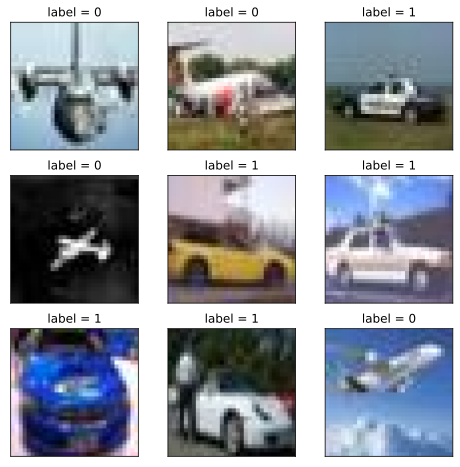

time: 416 ms (started: 2021-08-13 14:04:11 +08:00)


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [6]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)
time: 160 ms (started: 2021-08-13 14:04:14 +08:00)


### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建模型。

In [7]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

In [8]:
import datetime
import os

# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
from pathlib import Path
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./data/autograph/' + stamp))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 9s 17ms/step - loss: 0.4323 - accuracy: 0.7986 - val_loss: 0.3124 - val_accuracy: 0.8645
Epoch 2/10
100/100 [==============================] - 1s 12ms/step - loss: 0.3155 - accuracy: 0.8636 - val_loss: 0.2676 - val_accuracy: 0.8865
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.2571 - accuracy: 0.8947 - val_loss: 0.2463 - val_accuracy: 0.8940
Epoch 4/10
100/100 [==============================] - 1s 12ms/step - loss: 0.2164 - accuracy: 0.9130 - val_loss: 0.2158 - val_accuracy: 0.9130
Epoch 5/10
100/100 [==============================] - 1s 11ms/step - loss: 0.1896 - accuracy: 0.9231 - val_loss: 0.1956 - val_accuracy: 0.9190
Epoch 6/10
100/100 [==============================] - 1s 13ms/step - loss: 0.1614 - accuracy: 0.9368 - val_loss: 0.1682 - val_accuracy: 0.9290
Epoch 7/10
100/100 [==============================] - 1s 13ms/step - loss: 0.1474 - accuracy: 0.9417 - val_loss: 0.1862 - val_accuracy: 0.9270

### 四，评估模型

In [9]:
%load_ext tensorboard
#%tensorboard --logdir ./data/keras_model

time: 8.4 ms (started: 2021-08-13 14:04:56 +08:00)


In [10]:
from tensorboard import notebook
notebook.list() 

No known TensorBoard instances running.
time: 1.52 ms (started: 2021-08-13 14:04:58 +08:00)


In [ ]:
#在tensorboard中查看模型
notebook.start("--logdir ./data/keras_model")

![](./data/1-2-tensorboard.jpg)

In [13]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.432324,0.7986,0.312388,0.8645
2,0.315474,0.8636,0.267586,0.8865
3,0.257147,0.8947,0.246337,0.8940
4,0.216423,0.9130,0.215817,0.9130
5,0.189551,0.9231,0.195623,0.9190
6,0.161445,0.9368,0.168236,0.9290
7,0.147443,0.9417,0.186249,0.9270
8,0.124902,0.9523,0.169116,0.9295
9,0.108362,0.9602,0.173733,0.9295


time: 28.1 ms (started: 2021-08-13 14:06:34 +08:00)


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

time: 20.7 ms (started: 2021-08-13 14:06:45 +08:00)


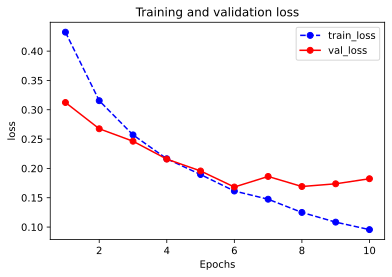

time: 207 ms (started: 2021-08-13 14:06:47 +08:00)


In [15]:
plot_metric(history,"loss")

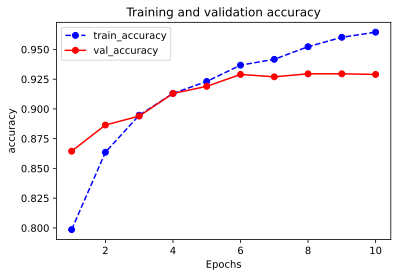

time: 201 ms (started: 2021-08-13 14:06:52 +08:00)


In [16]:
plot_metric(history,"accuracy")

In [17]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 0s 7ms/step - loss: 0.1824 - accuracy: 0.9290
0.1823989748954773 0.9290000200271606
time: 260 ms (started: 2021-08-13 14:07:06 +08:00)


```
0.16139143370091916 0.9345
```

### 五，使用模型

可以使用model.predict(ds_test)进行预测。

也可以使用model.predict_on_batch(x_test)对一个批量进行预测。

In [18]:
model.predict(ds_test)

array([[9.6440947e-01],
       [9.7116774e-01],
       [1.0870089e-03],
       ...,
       [9.8367357e-01],
       [7.5626222e-06],
       [9.9058002e-01]], dtype=float32)

time: 248 ms (started: 2021-08-13 14:07:09 +08:00)


In [19]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[8.9550650e-01]
 [9.5160645e-01]
 [9.9967408e-01]
 [9.9999821e-01]
 [8.5599743e-02]
 [1.1633613e-02]
 [5.7751000e-01]
 [9.9994075e-01]
 [9.5573990e-03]
 [9.9965978e-01]
 [4.4578558e-04]
 [5.3972662e-03]
 [7.7065863e-03]
 [1.0480047e-01]
 [9.9934250e-01]
 [8.8565099e-01]
 [2.8667941e-05]
 [9.9763548e-01]
 [5.5557415e-03]
 [6.9005759e-03]]
time: 436 ms (started: 2021-08-13 14:07:18 +08:00)


### 六，保存模型

推荐使用TensorFlow原生方式保存模型。

In [20]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format = "tf")

time: 53.4 ms (started: 2021-08-13 14:07:43 +08:00)


In [ ]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

```
[0.16139124035835267, 0.9345]
```

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋二维码.jpg](./data/算法美食屋二维码.jpg)